In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: C:\Users\Stefa\Documents\git\lmondada\qhack21


In [2]:
from utils.data_handling import load_data, get_combined_cov_pos
from utils.dataset import Dataset
from utils.linalg import so3_to_su2, to_so3
from encoding import encode
import pennylane.numpy as np
import pennylane as qml
import pandas as pd

In [5]:
data = Dataset(load_data()[:1000])
train_data, test_data = data.get_train_and_test()

def get_y(cov):
    eigs, _ = np.linalg.eigh(cov)
    eigs = np.log(eigs)/20
    return eigs
    
train_x = [x[:2] for x in train_data]
train_y = [get_y(x[2]) for x in train_data]
test_x = [x[:2] for x in test_data]
test_y = [get_y(x[2]) for x in test_data]

Reading data... ok
Filtering dataset... ok
Computing covmats... ok
Returning dataset with 79/20 training/testing datapoints


In [6]:
selected_ind = [0, 1]
wires = np.arange(5 * len(selected_ind))
dev = qml.device('default.qubit', wires=wires)

def layer(params=None, count_only=False):
    """
    A layer in our variational circuit
    
    If `count_only` is true, the function returns the number
    of necessary parameters.
    If `params` is None, then a dummy circuit is built and
    `count_only` must be set to true
    """
    if params is None and not count_only:
        raise ValueError("params cannot be None unless count_only=True")
        
    param_ind = 0
    def get_params(n = 1):
        """
        hands out trainable parameters from `params`
        
        Returns new parameter(s) at each call (assumes there
        are enough parameters available). The optional param
        `n` specifies how many parameters should be returned
        """
        nonlocal param_ind
        ret = []
        for i in range(n):
            if count_only:
                ret.append(0)
            else:
                ret.append(params[param_ind])
            param_ind += 1
        return ret if len(ret) > 1 else ret[0]
    
    qml.templates.AngleEmbedding(get_params(5), wires[:5], rotation='X')
    qml.templates.AngleEmbedding(get_params(5), wires[:5], rotation='Z')
    qml.templates.AngleEmbedding(get_params(5), wires[:5], rotation='X')

    # entangle position t0 with t1
    for ind in np.arange(3):
        q0 = wires[ind]
        q1 = wires[ind+5]
        qml.CRY(get_params(),wires=[q0, q1])
    # entangle cov(t0) with pos(t1)
    for ind in np.arange(3, 5):
        q0 = wires[ind]
        for jnd in np.arange(5, 8):
            q1 = wires[jnd]
            qml.CRY(get_params(),wires=[q0,q1])
    # entangle cov(t1) with pos(t1)
    for ind in np.arange(8, 10):
        q0 = wires[ind]
        for jnd in np.arange(5, 8):
            q1 = wires[jnd]
            qml.CRY(get_params(),wires=[q0,q1])
    
    qml.templates.AngleEmbedding(get_params(3), wires[5:8], rotation='X')
    qml.templates.AngleEmbedding(get_params(3), wires[5:8], rotation='Z')
    qml.templates.AngleEmbedding(get_params(3), wires[5:8], rotation='X')
    
    if count_only:
        return param_ind

@qml.qnode(dev)
def circ(covs, params):
    for ind, cov in enumerate(covs):
        encode(cov, wires=wires[5*ind:5*(ind+1)])
    layer(params)
    return [qml.expval(qml.PauliZ(wires=i)) for i in wires[5:8]]

def model(covs, params):
    out = circ(covs, params)
    alphas = 2*np.arccos(np.sqrt(.5 * (out[:3] + 1)))
    return alphas

n_params = layer(count_only=True)
circ(train_x[0], np.random.rand(n_params))
print(circ.draw())

 0: ──RX(0.282)───RX(0.505)──RZ(0.363)───RX(0.404)───────────────────────────────────────╭C───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤     
 1: ──RX(0.37)────RX(0.415)──RZ(0.527)───RX(0.584)───────────────────────────╭C──────────│────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤     
 2: ──RX(0.52)────RX(0.312)──RZ(0.429)───RX(0.277)───────────────╭C──────────│───────────│────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤     
 3: ──H──────────╭C──────────RZ(-0.999)──RX(1.2)─

In [10]:
params = np.zeros(n_params)

opt = qml.AdamOptimizer(0.02)

# only take a small subset
train_x = train_x[:100]
train_y = train_y[:100]
test_x = test_x[:100]
test_y = test_y[:100]

def cost(x, y, params):
    out = model(x, params)
    return np.linalg.norm(out - y)**2

def accuracy(train_x, train_y, params):
    mse = 0
    for x,y in zip(train_x, train_y):
        mse += np.sqrt(cost(x, y, params)) / np.linalg.norm(y)
    return mse / len(train_x)

baseline_accuracy = accuracy(train_x, train_y, params)
print(f"Baseline error: {baseline_accuracy:.1%}")

n_epoch = 100

opti_error = pd.DataFrame(columns=['epoch', 'error', 'type'])

for epoch in np.arange(n_epoch):
    def obj_fn(params):
        loss = 0
        for x, y in zip(train_x, train_y):
            loss += cost(x, y, params)
        return loss
    params, current_loss = opt.step_and_cost(obj_fn, params)
    mse = accuracy(train_x, train_y, params)
    opti_error = opti_error.append({
        'epoch': epoch,
        'error': mse,
        'type': "training"
    }, ignore_index=True)
    test_error = accuracy(test_x, test_y, params)
    opti_error = opti_error.append({
        'epoch': epoch,
        'error': test_error,
        'type': "test"
    }, ignore_index=True)

    print(f"Epoch {epoch}: {mse:.1%} / testing error {test_error:.1%}")
    
train_accuracy = accuracy(train_x, train_y, params)
print(f"Final training error: {train_accuracy:.1%}")

Baseline error: 7.2%
Epoch 0: 5.9% / testing error 16.8%
Epoch 1: 7.6% / testing error 18.4%
Epoch 2: 9.3% / testing error 20.2%
Epoch 3: 10.1% / testing error 21.1%
Epoch 4: 10.5% / testing error 21.6%
Epoch 5: 10.5% / testing error 21.6%
Epoch 6: 10.3% / testing error 21.3%
Epoch 7: 10.0% / testing error 21.0%
Epoch 8: 9.6% / testing error 20.6%
Epoch 9: 8.9% / testing error 19.9%
Epoch 10: 8.1% / testing error 19.0%
Epoch 11: 7.0% / testing error 17.8%
Epoch 12: 6.1% / testing error 16.8%
Epoch 13: 5.8% / testing error 16.6%
Epoch 14: 5.9% / testing error 16.8%
Epoch 15: 5.8% / testing error 16.8%
Epoch 16: 5.7% / testing error 16.7%
Epoch 17: 5.7% / testing error 16.8%
Epoch 18: 5.8% / testing error 17.0%
Epoch 19: 5.8% / testing error 17.1%
Epoch 20: 5.7% / testing error 17.0%
Epoch 21: 5.7% / testing error 17.0%
Epoch 22: 6.0% / testing error 17.3%
Epoch 23: 6.1% / testing error 17.4%
Epoch 24: 5.8% / testing error 17.0%
Epoch 25: 5.3% / testing error 16.4%
Epoch 26: 4.9% / testi

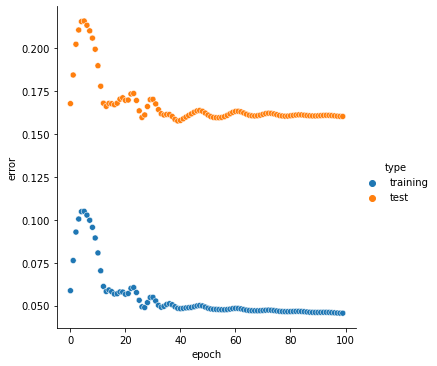

In [11]:
import seaborn as sns

sns.relplot(data=opti_error, x='epoch', y='error', hue='type')

In [13]:
print(f"Init baseline error (train): {accuracy(train_x, train_y, np.zeros(n_params)):.1%}")
print(f"Final baseline error (train): {accuracy(train_x, train_y, params):.1%}")

Init baseline error (train): 7.2%
Final baseline error (train): 4.6%


In [12]:
print(f"Init baseline error (test): {accuracy(test_x, test_y, np.zeros(n_params)):.1%}")
print(f"Final baseline error (test): {accuracy(test_x, test_y, params):.1%}")

Init baseline error (test): 19.4%
Final baseline error (test): 16.0%
